In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=7, micro=1, releaselevel='final', serial=0)
matplotlib 3.0.2
numpy 1.18.1
pandas 1.0.1
sklearn 0.20.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
en_spa_file_path = './data_spa_en/spa.txt'

import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
en_sentence = 'I stayed.'
sp_sentence = 'Me quedé.'
print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

I stayed.
Me quede.


In [3]:
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = re.sub(r'[^a-zA-Z?.!,¿]', " ", s)
    s = s.rstrip().strip()
    s = '<start> ' + s + ' <end>'
    return s
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> i stayed . <end>
<start> me quede . <end>


In [4]:
def parse_data(filename):
    lines = open(filename, encoding='UTF-8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    preprocess_sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs
    ]
    return zip(*preprocess_sentence_pairs)

en_dataset, sp_dataset = parse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [5]:
a = [(1, 2), (3, 4), (5, 6)]
c, d = zip(*a)
c, d

((1, 3, 5), (2, 4, 6))

In [6]:
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters='', split=' ')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[:30000])

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

16 11


In [7]:
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor, output_tensor, test_size=0.2)
len(input_train), len(input_eval), len(output_train), len(output_eval)

(24000, 6000, 24000, 6000)

In [8]:
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print('%d --> %s' % (t, tokenizer.index_word[t]))

convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)

1 --> <start>
2347 --> mantuve
19 --> mi
393 --> boca
1284 --> cerrada
3 --> .
2 --> <end>

1 --> <start>
4 --> i
452 --> kept
21 --> my
532 --> mouth
400 --> shut
3 --> .
2 --> <end>


In [9]:
def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder=True)
    return dataset

batch_size = 64
epochs = 20
train_dateset = make_dataset(input_train, output_train, batch_size, epochs, True)
eval_dateset = make_dataset(input_eval, output_eval, batch_size, 1, False)

In [10]:
for x, y in train_dateset.take(1):
    print(x.shape)
    print(y.shape)    
    print(x)    
    print(y)    

(64, 16)
(64, 11)
tf.Tensor(
[[   1   75   56 ...    0    0    0]
 [   1   23 1235 ...    0    0    0]
 [   1   24   20 ...    0    0    0]
 ...
 [   1  210   28 ...    0    0    0]
 [   1  654   13 ...    0    0    0]
 [   1    6  235 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1   16   23  252    3    2    0    0    0    0    0]
 [   1    4   38   94    6   15    5    3    2    0    0]
 [   1    4   18   33  592    3    2    0    0    0    0]
 [   1   64  170  144   39    3    2    0    0    0    0]
 [   1   60   11    5    7    2    0    0    0    0    0]
 [   1    6   35  188    3    2    0    0    0    0    0]
 [   1    5 2515    3    2    0    0    0    0    0    0]
 [   1    4   18  103   31  206    3    2    0    0    0]
 [   1    4   72   31 1032    3    2    0    0    0    0]
 [   1   13  298    8  780    3    2    0    0    0    0]
 [   1   42    6  112  242    7    2    0    0    0    0]
 [   1    4   38   94   41    3    2    0    0    0    0]
 [   1

In [11]:
embedding_units = 256
units = 1024
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

In [12]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(
            self.encoding_units, 
            return_sequences=True, 
            return_state=True, 
            recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)

print(sample_output.shape)
print(sample_hidden.shape)

(64, 16, 1024)
(64, 1024)


In [13]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (batch_size, units1024)
        # encoder_outputs: (batch_size, length, units1024)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        # (batch_size, length, units1024) -> (batch_size, length, 1)
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1) # (batch_size, length, 1)
        context_vector = attention_weights * encoder_outputs # (batch_size, length, units1024)
        context_vector = tf.reduce_sum(context_vector, axis=1) # (batch_size, units1024)
        return context_vector, attention_weights

attention_model = BahdanauAttention(units=10)
attention_results, attention_weights = attention_model(sample_hidden, sample_output)
print(attention_results.shape)
print(attention_weights.shape)

(64, 1024)
(64, 16, 1)


In [14]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units, 
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
        
    def call(self, x, hidden, encoding_outputs):
        # context_vector: (batch_size, units)
        context_vector, attention_weights = self.attention(hidden, encoding_outputs)
        # (batch_size, 1) -> (batch_size, 1, embedding_units)
        x = self.embedding(x)
        combined_x = tf.concat(
            [tf.expand_dims(context_vector, 1), x], axis=-1)
        # output: (batch_size, 1, decoding_units)
        # state: (batch_size, decoding_units)
        output, state = self.gru(combined_x)
        # (batch_size, decoding_units)
        output = tf.reshape(output, (-1, output.shape[2]))
        # (batch_size, vocab_size)
        output = self.fc(output)
        return output, state, attention_weights
    
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)
outputs = decoder(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)
decoder_output, decoder_hidden, decoder_aw = outputs
print(decoder_output.shape)
print(decoder_hidden.shape)
print(decoder_aw.shape)

(64, 4935)
(64, 1024)
(64, 16, 1)


In [15]:
optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [16]:
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
        decoding_hidden = encoding_hidden
        for t in range(0, targ.shape[1] - 1):
            decoding_input = tf.expand_dims(targ[:, t], 1)
            predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(targ[:, t+1], predictions)
    
    batch_loss = loss / int(targ.shape[0])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [17]:
epochs = 5
steps_per_epoch = len(input_tensor) // batch_size
for epoch in range(epochs):
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(train_dateset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print(epoch + 1, batch, batch_loss.numpy())
    print(epuch + 1, total_loss / steps_per_epoch)

1 0 0.7930926


KeyboardInterrupt: 

In [21]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    input_sentence = preprocess_sentence(input_sentence)
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_input, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    results = ''
    encoding_hidden = tf.zeros((1, units))
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    # decoding_input： (1, 1)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']], 0)
    for t in range(max_length_output):
        # attention_weights (batch_size1, input_length16, 1)
        predictions, decoding_hidden, attention_weights = decoder(decoding_input, decoding_hidden, encoding_outputs)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_matrix[t] = attention_weights.numpy()
        # predictions (batch_size1, vocab_size4935)
        predicted_id = tf.argmax(predictions[0]).numpy()
        results += output_tokenizer.index_word[predicted_id] + ' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        decoding_input = tf.expand_dims([predicted_id], 0)
    return results, input_sentence, attention_matrix

In [22]:
def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap='viridis')
    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict=font_dict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict)
    plt.show()

def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    print('input:', input_sentence)
    print('output:', results)    
    attention_matrix = attention_matrix[:len(results.split(' ')),
                                       :len(input_sentence.split(' '))]
    plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))

input: <start> eso es todo lo que puedo decir en este momento . <end>
output: i . <end> 


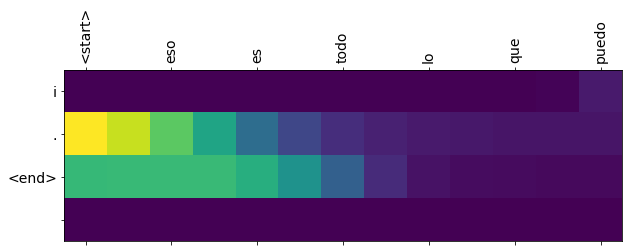

In [25]:
translate('Eso es todo lo que puedo decir en este momento.')